500


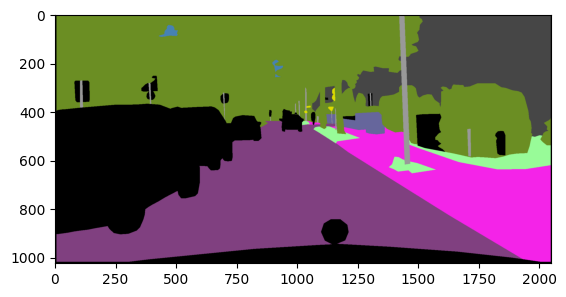

In [1]:
######### DATASET #########
#fine tuning SAM2 with Cityscapes dataset
import os, sys
import numpy as np
KD_path = "/home/avalocal/thesis23/KD"
sys.path.append(KD_path)
#images 
#annorations: labelIds
#prompts: bboxes from labelIds (might consider or not)
import os, sys, glob, cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from labels import labels

dic = {0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky'}
num_to_color = {
    0: [128, 64, 128],
    1: [244, 35, 232],
    2: [70, 70, 70],
    3: [102, 102, 156],
    4: [190, 153, 153],
    5: [153, 153, 153],
    6: [250, 170, 30],
    7: [220, 220, 0],
    8: [107, 142, 35],
    9: [152, 251, 152],
    10: [70, 130, 180]
}

id2trainId = { label.id: label.trainId for label in labels }
trainId2color = { label.trainId: label.color for label in labels }

#dataset getting images and labels
class Cityscapes(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        if self.split in ['train', 'val', 'test']:
            self.image_dir = os.path.join(self.root_dir, 'leftImg8bit', self.split)
            self.label_dir = os.path.join(self.root_dir, 'gtFine', self.split)
            self.image_files = glob.glob(os.path.join(self.image_dir, '*/*'))
            self.label_files = glob.glob(os.path.join(self.label_dir, '*/*_labelIds.png'))
            self.color_files = glob.glob(os.path.join(self.label_dir, '*/*_color.png'))
            self.image_files.sort()
            self.label_files.sort()
            self.color_files.sort()
        elif self.split in ['train_extra']:
            self.image_dir = os.path.join(self.root_dir, 'leftImg8bit', 'train_extra')
            self.image_files = glob.glob(os.path.join(self.image_dir, '*/*'))
            #shuffle the images
            np.random.shuffle(self.image_files)
            #pick only 3000 images
            self.image_files = self.image_files[:3000]

        self.stuff_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.instace_classes = [11, 12, 13, 14, 15, 16, 17, 18, 19]
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):

        
        assert os.path.exists(self.image_files[idx]), self.image_files[idx]

        file_name = os.path.basename(self.image_files[idx])


        # print(len(self.image_files), len(self.label_files))
        image = cv2.imread(self.image_files[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #H, W, C
        cropped_image = image[0:970, 0:2048]
        image = cv2.resize(cropped_image, (2048, 1024), interpolation=cv2.INTER_LINEAR)
        image = torch.from_numpy(image).permute(2, 0, 1).float() #3, H, W
        image = image / 255.0
        # print(self.label_files[idx])

        if self.split in ['train', 'val', 'test']:
            label_rgb = cv2.imread(self.color_files[idx], cv2.IMREAD_COLOR)
            label_rgb = cv2.cvtColor(label_rgb, cv2.COLOR_BGR2RGB) #H, W, C
            label_rgb = torch.from_numpy(label_rgb)
            label = cv2.imread(self.label_files[idx], cv2.IMREAD_GRAYSCALE) #H, W
            label = np.vectorize(id2trainId.get)(label)
            label = torch.from_numpy(label).unsqueeze(0).float() #1, H, W
       
            #stuff label
            label_rgb_stuff = torch.zeros(label.size(1), label.size(2), 3).to(torch.long)
            for i in range(11):
                # label_rgb_stuff = label_rgb_stuff.to(torch.long)  # Ensure destination tensor is Long
                label_rgb_stuff[(label == i).squeeze()] = torch.tensor(num_to_color[i], dtype=torch.long)



            N = 11 # 11 stuff classes + 1 void class
            stuff_label= torch.zeros(N, label.size(1), label.size(2))
            for i in range(N):
                stuff_label[i] = (label == i).float()
        
            return image, label_rgb_stuff, stuff_label  # 3, H, W | 12, H, W
        elif self.split in ['train_extra']:
            return image, file_name
    




# train_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes", split='train')
train_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",
            split='val')
# print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

train_batch_size = 4
num_train_workers = 4
print(len(train_dataset))

img, label_rgb, stuff_label = next(iter(train_loader))
#show rgb label
plt.imshow(label_rgb[0])


In [2]:
#########FINE TUNING CLIPSEG#########
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from tqdm import tqdm

finetuning = False 
if finetuning:
    processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    epochs = 100

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2, betas=(0.9, 0.999))
    # optimizer = ADOPT(model.parameters(), lr=5e-5,decouple=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=1e-8)
    dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    texts = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign", "vegetation", "terrain", "sky"]

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0

        for _, batch in enumerate(tqdm(dataloader)):
            images, masks = batch
            images = images[0].to(device)
            
            inputs = processor(text=texts,images=[images] * len(texts), padding=True, return_tensors="pt")
            # inputs = {key: value.to(device) for key, value in inputs.items()}
            masks = masks[0].to(device) #11, H, W
            for k in inputs.keys():
                inputs[k] = inputs[k].to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            # print(logits.shape, masks.shape) # 11, 352, 352 | 11, 1024, 2048

            # approach 1) upscale logits to the size of masks
            logits = logits.unsqueeze(0)
            logits = torch.nn.functional.interpolate(logits, size=(masks.size(1), masks.size(2)), mode="bilinear", align_corners=False)
            logits = logits.squeeze(0)

            # 2) approach Downsample masks to the size of logits
            # masks = torch.nn.functional.interpolate(masks.unsqueeze(0), size=(logits.size(1), logits.size(2)), mode="bilinear", align_corners=False)
            # masks = masks.squeeze(0)


            # print(logits.shape, masks.shape)
            # print(logits.requires_grad, masks.requires_grad,"logits, masks require grad") #True, False

            # Compute loss for each class (assuming masks are binary)
            loss = criterion(logits, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

    #save the model
    torch.save(model.state_dict(), "/home/avalocal/thesis23/KD/sam2/checkpoints/clipseg_finetuned_semantic_cityscapes_1e-5_100epochs.pth")

/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(


In [13]:
#########EVALUATION#########
import os, json, os
import numpy as np
from tqdm import tqdm
import sys, os
import torch, random
import torch.nn as nn
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
from hydra import initialize
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import matplotlib.pyplot as plt


def compute_miou(pred, gt):

    num_classes = torch.unique(gt).size(0)
    #pred H, W, C
    #gt H, W, C
    
    ious = []
    for i in range(num_classes):
        pred_i = pred == i
        gt_i = gt == i
        intersection = (pred_i & gt_i).sum()
        union = (pred_i | gt_i).sum()
        iou = intersection / union
        ious.append(iou.item())
    #mean iou of not nan values
    miou = np.nanmean(ious)
    
    return miou

In [14]:

#stuff classes 11-class
dic = {0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky'}
num_to_color = {0: [128, 64, 128], 1: [244, 35, 232], 2: [70, 70, 70], 3: [102, 102, 156],
                4: [190, 153, 153], 5: [153, 153, 153],6: [250, 170, 30], 7: [220, 220, 0],
                8: [107, 142, 35], 9: [152, 251, 152], 10: [70, 130, 180]}

def colorize_mask(mask):
    mask = mask.detach().cpu().numpy()
    color_mask = np.zeros((mask.shape[1], mask.shape[2], 3))
    for i in range(mask.shape[0]):
        color = num_to_color[i]
        color_mask[mask[i] == 1] = color
    return color_mask



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam2_checkpoint = "/home/avalocal/thesis23/KD/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml"
#/home/avalocal/thesis23/KD/sam2/sam2/configs/sam2.1

# Replace this path with the actual path to your config directory
# config_dir = "sam2/sam2/configs/sam2.1"
config_dir = "sam2/sam2/configs/sam2.1"
with initialize(version_base=None, config_path=config_dir):
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)


In [15]:
######VALIDATION or saving the pseudo labels########
val_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",split='val')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

# print(len(val_dataset))
#set seed
torch.manual_seed(0)
sampling = 10 # more than 15 make it less accurate!!!
threshold = 0.45

val_flag= True
if val_flag:
    processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

    ##ckpt = "/home/avalocal/thesis23/KD/sam2/checkpoints/clipseg_finetuned_semantic_cityscapes_1e-4.pth"
    ckpt="/home/avalocal/thesis23/KD/sam2/checkpoints/clipseg_finetuned_semantic_cityscapes_1e-5.pth"
    dict = torch.load(ckpt)
    model.load_state_dict(dict)
    save_dir = "/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes/gCLIP/train_extra"
    model.eval()

    MIOU= 0.0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader)):

            frame = i
            image,gt_rgb_mask, _= batch ##1, 3, H, W | 1,11, H, W

            # image, filename = batch
            # filename = filename[0]
            
            stuff_mask = torch.zeros(len(dic), 1024, 2048)
            assigned_pixels = torch.zeros(1024, 2048, dtype=torch.bool)
            points =torch.zeros(len(dic), sampling, 2)
            image *=255.0
            image=image[0].permute(1, 2, 0).numpy().copy()#.astype(np.uint8) #H, W, 3
            image = image.astype(np.uint8)
            # gt_rgb_mask = gt_rgb_mask[0].cpu().numpy()#.transpose(1, 2, 0)        

            for j in range(len(dic)):            
                prompt = f"{dic[j]}"
                inputs = processor(text=prompt, images=image, padding=True, return_tensors="pt")
                outputs = model(**inputs)
                logits = outputs.logits
                logits = logits.unsqueeze(0)
                logits = torch.nn.functional.interpolate(logits, size=(1024, 2048), mode="bilinear", align_corners=False)
                logits = logits.squeeze(0)
                logits = logits.sigmoid()
                mask = logits > threshold
                mask = mask & ~assigned_pixels

                stuff_mask[j] = mask
                assigned_pixels = assigned_pixels | mask
                
            for k in range(len(dic)):

                idx_points = torch.nonzero(stuff_mask[k], as_tuple=False)
                if idx_points.size(0) >= sampling:
                    selected_indices = random.sample(range(idx_points.size(0)), sampling)
                    selected_points = idx_points[selected_indices]
                else:
                    selected_points = torch.zeros(sampling, 2, dtype=torch.int64)
                    selected_points[:idx_points.size(0)] = idx_points
                points[k] = selected_points
            color_mask = colorize_mask(stuff_mask) #1024, 2048, 3
            color_mask = color_mask.astype(np.uint8)

            predictor.set_image(image)
            genral_mask = torch.zeros(len(dic), 1024, 2048)
            
            for z in range(len(dic)):            
                prompt = f"{dic[z]}"
                points_ = points[z]
                points_ = points_[:, [1, 0]]
                
                tmp, scores, _ = predictor.predict(
                    point_coords=points_,
                    point_labels=[1]*len(points_),
                    multimask_output=False,
                )
                tmp = tmp.squeeze(0)
                tmp = torch.from_numpy(tmp).to(device)
                genral_mask[z] = tmp
                
            pseudo_mask = colorize_mask(genral_mask)
            pseudo_mask = pseudo_mask.astype(np.uint8)
            
            save =False
            if save:
                #save in the directory/cityscapes/gCLIP/train_extra/city/imagename.png
                city=filename.split("_")[0]
                save_path = os.path.join(save_dir, city)
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                # heilbronn_000000_000531_leftImg8bit.png -> # heilbronn_000000_000531_gclip_color.png
                filename = filename.replace("leftImg8bit", "gclip_color")
                save_path = os.path.join(save_path, filename)
                Image.fromarray(pseudo_mask).save(save_path)
                output = np.zeros_like(color_mask)
                for i in range(len(dic)):
                    color = num_to_color[i]
                    class_mask = np.all(gt_rgb_mask == color, axis=-1)
                    output[class_mask] = color
            
                
            #show psudo mask and gt rgb mask
            #gt_rgb_mask -> [1, 1024, 2048, 3]
            # gt_rgb_mask = gt_rgb_mask[0].cpu().numpy()
            gt_rgb_mask = gt_rgb_mask[0]
            
            


            print(pseudo_mask.shape, gt_rgb_mask.shape)
            # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            # ax[0].imshow(pseudo_mask)
            # ax[0].set_title("Pseudo mask") #H, W, 3
            # ax[1].imshow(gt_rgb_mask)
            # ax[1].set_title("GT mask") #H, W, 3
            # plt.show()
            print(type(pseudo_mask), type(gt_rgb_mask)) #numpy, tensor
            pseudo_mask = torch.from_numpy(pseudo_mask)


            miou_ = compute_miou(pseudo_mask, gt_rgb_mask)
            print(f"MIoU for frame {frame}: {miou_}")
            MIOU += miou_

        print(f"Mean IoU: {MIOU / 500}")

        




  0%|          | 0/500 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>
MIoU for frame 0: 0.371706485748291
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  0%|          | 2/500 [00:05<23:18,  2.81s/it]

MIoU for frame 1: 0.4938819408416748
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  1%|          | 3/500 [00:08<21:49,  2.64s/it]

MIoU for frame 2: 0.5382415652275085
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  1%|          | 4/500 [00:11<22:45,  2.75s/it]

MIoU for frame 3: 0.5682397484779358
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  1%|          | 5/500 [00:13<21:53,  2.65s/it]

MIoU for frame 4: 0.3118884563446045
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  1%|          | 6/500 [00:16<21:35,  2.62s/it]

MIoU for frame 5: 0.32947608828544617
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  1%|▏         | 7/500 [00:18<21:48,  2.65s/it]

MIoU for frame 6: 0.4088532626628876
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  2%|▏         | 8/500 [00:21<22:17,  2.72s/it]

MIoU for frame 7: 0.49974051117897034
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  2%|▏         | 9/500 [00:24<22:18,  2.73s/it]

MIoU for frame 8: 0.5567197799682617
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  2%|▏         | 10/500 [00:26<21:36,  2.65s/it]

MIoU for frame 9: 0.29944083094596863
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  2%|▏         | 11/500 [00:29<21:34,  2.65s/it]

MIoU for frame 10: 0.27951517701148987
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  2%|▏         | 12/500 [00:32<21:37,  2.66s/it]

MIoU for frame 11: 0.3746744990348816
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  3%|▎         | 13/500 [00:34<21:03,  2.59s/it]

MIoU for frame 12: 0.3119053244590759
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  3%|▎         | 14/500 [00:37<21:13,  2.62s/it]

MIoU for frame 13: 0.345084547996521
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  3%|▎         | 15/500 [00:39<21:01,  2.60s/it]

MIoU for frame 14: 0.26399680972099304
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  3%|▎         | 16/500 [00:42<20:34,  2.55s/it]

MIoU for frame 15: 0.22237271070480347
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  3%|▎         | 17/500 [00:45<20:45,  2.58s/it]

MIoU for frame 16: 0.2610146403312683
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  4%|▎         | 18/500 [00:47<21:08,  2.63s/it]

MIoU for frame 17: 0.24998924136161804
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  4%|▍         | 19/500 [00:50<20:41,  2.58s/it]

MIoU for frame 18: 0.30896157026290894
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  4%|▍         | 20/500 [00:52<20:41,  2.59s/it]

MIoU for frame 19: 0.3037339746952057
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  4%|▍         | 21/500 [00:55<20:41,  2.59s/it]

MIoU for frame 20: 0.38494595885276794
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  4%|▍         | 22/500 [00:58<20:34,  2.58s/it]

MIoU for frame 21: 0.5440046787261963
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  5%|▍         | 23/500 [01:01<22:07,  2.78s/it]

MIoU for frame 22: 0.22177498042583466
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  5%|▍         | 24/500 [01:04<22:03,  2.78s/it]

MIoU for frame 23: 0.22267495095729828
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  5%|▌         | 25/500 [01:06<21:04,  2.66s/it]

MIoU for frame 24: 0.31693515181541443
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  5%|▌         | 26/500 [01:09<20:57,  2.65s/it]

MIoU for frame 25: 0.4202013313770294
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  5%|▌         | 27/500 [01:11<20:47,  2.64s/it]

MIoU for frame 26: 0.4319404065608978
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  6%|▌         | 28/500 [01:14<20:27,  2.60s/it]

MIoU for frame 27: 0.2514256238937378
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  6%|▌         | 29/500 [01:19<27:12,  3.47s/it]

MIoU for frame 28: 0.43881678581237793
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  6%|▌         | 30/500 [01:22<26:10,  3.34s/it]

MIoU for frame 29: 0.5921748876571655
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  6%|▌         | 31/500 [01:25<24:39,  3.15s/it]

MIoU for frame 30: 0.35035741329193115
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  6%|▋         | 32/500 [01:28<24:03,  3.08s/it]

MIoU for frame 31: 0.3288322389125824
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  7%|▋         | 33/500 [01:31<23:14,  2.99s/it]

MIoU for frame 32: 0.5121079683303833
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  7%|▋         | 34/500 [01:33<22:25,  2.89s/it]

MIoU for frame 33: 0.23176738619804382
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  7%|▋         | 35/500 [01:37<24:58,  3.22s/it]

MIoU for frame 34: 0.4697398543357849
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  7%|▋         | 36/500 [01:41<26:19,  3.40s/it]

MIoU for frame 35: 0.21360184252262115
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  7%|▋         | 37/500 [01:45<27:05,  3.51s/it]

MIoU for frame 36: 0.36460307240486145
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  8%|▊         | 38/500 [01:49<27:55,  3.63s/it]

MIoU for frame 37: 0.2500828504562378
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  8%|▊         | 39/500 [01:53<29:08,  3.79s/it]

MIoU for frame 38: 0.3806622326374054
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  8%|▊         | 40/500 [01:57<29:16,  3.82s/it]

MIoU for frame 39: 0.2542046010494232
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  8%|▊         | 41/500 [02:01<29:18,  3.83s/it]

MIoU for frame 40: 0.4103870987892151
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  8%|▊         | 42/500 [02:05<29:25,  3.86s/it]

MIoU for frame 41: 0.40735357999801636
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  9%|▊         | 43/500 [02:09<29:40,  3.90s/it]

MIoU for frame 42: 0.3978363573551178
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  9%|▉         | 44/500 [02:13<30:29,  4.01s/it]

MIoU for frame 43: 0.5642354488372803
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  9%|▉         | 45/500 [02:18<32:38,  4.31s/it]

MIoU for frame 44: 0.370463490486145
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  9%|▉         | 46/500 [02:22<31:57,  4.22s/it]

MIoU for frame 45: 0.36013662815093994
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


  9%|▉         | 47/500 [02:25<30:28,  4.04s/it]

MIoU for frame 46: 0.32182592153549194
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 10%|▉         | 48/500 [02:29<30:12,  4.01s/it]

MIoU for frame 47: 0.34036746621131897
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 10%|▉         | 49/500 [02:33<29:44,  3.96s/it]

MIoU for frame 48: 0.4318869411945343
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 10%|█         | 50/500 [02:37<29:22,  3.92s/it]

MIoU for frame 49: 0.31991031765937805
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 10%|█         | 51/500 [02:41<30:02,  4.02s/it]

MIoU for frame 50: 0.2431207001209259
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 10%|█         | 52/500 [02:45<30:08,  4.04s/it]

MIoU for frame 51: 0.18434740602970123
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 11%|█         | 53/500 [02:48<27:50,  3.74s/it]

MIoU for frame 52: 0.2315710335969925
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 11%|█         | 54/500 [02:51<26:15,  3.53s/it]

MIoU for frame 53: 0.36376848816871643
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 11%|█         | 55/500 [02:54<23:45,  3.20s/it]

MIoU for frame 54: 0.25834882259368896
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 11%|█         | 56/500 [02:57<22:20,  3.02s/it]

MIoU for frame 55: 0.3067892789840698
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 11%|█▏        | 57/500 [03:00<22:14,  3.01s/it]

MIoU for frame 56: 0.2635326385498047
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 12%|█▏        | 58/500 [03:02<21:12,  2.88s/it]

MIoU for frame 57: 0.40363386273384094
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 12%|█▏        | 59/500 [03:05<20:21,  2.77s/it]

MIoU for frame 58: 0.30129632353782654
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 12%|█▏        | 60/500 [03:07<19:56,  2.72s/it]

MIoU for frame 59: 0.3839099705219269
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 12%|█▏        | 61/500 [03:10<19:23,  2.65s/it]

MIoU for frame 60: 0.28483206033706665
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 12%|█▏        | 62/500 [03:12<18:49,  2.58s/it]

MIoU for frame 61: 0.3364107012748718
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 13%|█▎        | 63/500 [03:15<19:07,  2.63s/it]

MIoU for frame 62: 0.2814038395881653
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 13%|█▎        | 64/500 [03:17<18:39,  2.57s/it]

MIoU for frame 63: 0.3455717861652374
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 13%|█▎        | 65/500 [03:21<20:53,  2.88s/it]

MIoU for frame 64: 0.4599123001098633
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 13%|█▎        | 66/500 [03:24<20:34,  2.84s/it]

MIoU for frame 65: 0.3108270764350891
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 13%|█▎        | 67/500 [03:26<20:21,  2.82s/it]

MIoU for frame 66: 0.29703250527381897
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 14%|█▎        | 68/500 [03:29<19:49,  2.75s/it]

MIoU for frame 67: 0.37461718916893005
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 14%|█▍        | 69/500 [03:32<19:52,  2.77s/it]

MIoU for frame 68: 0.31783947348594666
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 14%|█▍        | 70/500 [03:34<19:20,  2.70s/it]

MIoU for frame 69: 0.23947256803512573
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 14%|█▍        | 71/500 [03:38<20:51,  2.92s/it]

MIoU for frame 70: 0.34530043601989746
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 14%|█▍        | 72/500 [03:41<20:41,  2.90s/it]

MIoU for frame 71: 0.3981473445892334
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 15%|█▍        | 73/500 [03:43<20:17,  2.85s/it]

MIoU for frame 72: 0.27999335527420044
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 15%|█▍        | 74/500 [03:46<20:13,  2.85s/it]

MIoU for frame 73: 0.30975523591041565
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 15%|█▌        | 75/500 [03:49<19:33,  2.76s/it]

MIoU for frame 74: 0.3700321912765503


 15%|█▌        | 76/500 [03:51<18:36,  2.63s/it]

(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>
MIoU for frame 75: 0.3389863669872284
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 15%|█▌        | 77/500 [03:56<24:00,  3.41s/it]

MIoU for frame 76: 0.5312625765800476
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 16%|█▌        | 78/500 [03:59<22:33,  3.21s/it]

MIoU for frame 77: 0.41469624638557434
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 16%|█▌        | 79/500 [04:02<21:16,  3.03s/it]

MIoU for frame 78: 0.4014563262462616
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 16%|█▌        | 80/500 [04:04<20:27,  2.92s/it]

MIoU for frame 79: 0.4134626090526581
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 16%|█▌        | 81/500 [04:07<19:53,  2.85s/it]

MIoU for frame 80: 0.5142656564712524
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 16%|█▋        | 82/500 [04:10<19:10,  2.75s/it]

MIoU for frame 81: 0.3654193878173828
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 17%|█▋        | 83/500 [04:12<18:47,  2.70s/it]

MIoU for frame 82: 0.3363356590270996
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 17%|█▋        | 84/500 [04:15<18:49,  2.71s/it]

MIoU for frame 83: 0.373188316822052
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 17%|█▋        | 85/500 [04:17<18:31,  2.68s/it]

MIoU for frame 84: 0.39457961916923523
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 17%|█▋        | 86/500 [04:20<18:44,  2.72s/it]

MIoU for frame 85: 0.39944496750831604
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 17%|█▋        | 87/500 [04:23<19:25,  2.82s/it]

MIoU for frame 86: 0.605453372001648
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 18%|█▊        | 88/500 [04:26<18:44,  2.73s/it]

MIoU for frame 87: 0.38124069571495056
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 18%|█▊        | 89/500 [04:28<18:23,  2.69s/it]

MIoU for frame 88: 0.30352982878685
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 18%|█▊        | 90/500 [04:31<17:33,  2.57s/it]

MIoU for frame 89: 0.4975723326206207
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 18%|█▊        | 91/500 [04:33<17:19,  2.54s/it]

MIoU for frame 90: 0.2801985442638397
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 18%|█▊        | 92/500 [04:36<17:27,  2.57s/it]

MIoU for frame 91: 0.3312917649745941
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 19%|█▊        | 93/500 [04:39<17:50,  2.63s/it]

MIoU for frame 92: 0.23128996789455414
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 19%|█▉        | 94/500 [04:41<17:33,  2.59s/it]

MIoU for frame 93: 0.4400743842124939
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 19%|█▉        | 95/500 [04:44<17:29,  2.59s/it]

MIoU for frame 94: 0.5808297395706177
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 19%|█▉        | 96/500 [04:47<18:43,  2.78s/it]

MIoU for frame 95: 0.4912961721420288
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 19%|█▉        | 97/500 [04:49<18:05,  2.69s/it]

MIoU for frame 96: 0.22181876003742218
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 20%|█▉        | 98/500 [04:52<18:27,  2.76s/it]

MIoU for frame 97: 0.452693909406662
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 20%|█▉        | 99/500 [04:55<18:34,  2.78s/it]

MIoU for frame 98: 0.4802192449569702
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 20%|██        | 100/500 [04:58<17:38,  2.65s/it]

MIoU for frame 99: 0.2975977063179016
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 20%|██        | 101/500 [05:00<17:39,  2.66s/it]

MIoU for frame 100: 0.4434428811073303
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 20%|██        | 102/500 [05:03<17:36,  2.65s/it]

MIoU for frame 101: 0.3144461512565613
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 21%|██        | 103/500 [05:05<17:27,  2.64s/it]

MIoU for frame 102: 0.30087345838546753
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 21%|██        | 104/500 [05:08<17:05,  2.59s/it]

MIoU for frame 103: 0.20696289837360382
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 21%|██        | 105/500 [05:11<17:13,  2.62s/it]

MIoU for frame 104: 0.2985921800136566
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 21%|██        | 106/500 [05:13<16:53,  2.57s/it]

MIoU for frame 105: 0.29821082949638367
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 21%|██▏       | 107/500 [05:16<16:41,  2.55s/it]

MIoU for frame 106: 0.19036036729812622
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 22%|██▏       | 108/500 [05:18<16:47,  2.57s/it]

MIoU for frame 107: 0.283308207988739
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 22%|██▏       | 109/500 [05:21<16:38,  2.55s/it]

MIoU for frame 108: 0.330230176448822
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 22%|██▏       | 110/500 [05:23<16:42,  2.57s/it]

MIoU for frame 109: 0.2599518299102783
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 22%|██▏       | 111/500 [05:26<16:51,  2.60s/it]

MIoU for frame 110: 0.34725987911224365
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 22%|██▏       | 112/500 [05:28<16:37,  2.57s/it]

MIoU for frame 111: 0.3575308620929718
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 23%|██▎       | 113/500 [05:31<16:07,  2.50s/it]

MIoU for frame 112: 0.24237798154354095
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 23%|██▎       | 114/500 [05:34<17:00,  2.64s/it]

MIoU for frame 113: 0.436369925737381
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 23%|██▎       | 115/500 [05:36<16:44,  2.61s/it]

MIoU for frame 114: 0.38760441541671753
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 23%|██▎       | 116/500 [05:40<19:01,  2.97s/it]

MIoU for frame 115: 0.3247881531715393
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 23%|██▎       | 117/500 [05:43<19:05,  2.99s/it]

MIoU for frame 116: 0.3914847671985626
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 24%|██▎       | 118/500 [05:48<22:40,  3.56s/it]

MIoU for frame 117: 0.4972991943359375
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 24%|██▍       | 119/500 [05:55<28:59,  4.57s/it]

MIoU for frame 118: 0.5381292700767517
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 24%|██▍       | 120/500 [05:59<27:42,  4.37s/it]

MIoU for frame 119: 0.3193979561328888
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 24%|██▍       | 121/500 [06:03<26:25,  4.18s/it]

MIoU for frame 120: 0.4982093870639801
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 24%|██▍       | 122/500 [06:07<25:56,  4.12s/it]

MIoU for frame 121: 0.3865983784198761
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 25%|██▍       | 123/500 [06:11<26:04,  4.15s/it]

MIoU for frame 122: 0.24959178268909454
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 25%|██▍       | 124/500 [06:14<23:58,  3.83s/it]

MIoU for frame 123: 0.26877033710479736
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 25%|██▌       | 125/500 [06:18<24:53,  3.98s/it]

MIoU for frame 124: 0.552821159362793
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 25%|██▌       | 126/500 [06:22<23:34,  3.78s/it]

MIoU for frame 125: 0.6331633925437927
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 25%|██▌       | 127/500 [06:25<23:24,  3.77s/it]

MIoU for frame 126: 0.35543981194496155
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 26%|██▌       | 128/500 [06:28<22:12,  3.58s/it]

MIoU for frame 127: 0.48747488856315613
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 26%|██▌       | 129/500 [06:32<22:11,  3.59s/it]

MIoU for frame 128: 0.48548048734664917
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 26%|██▌       | 130/500 [06:36<22:11,  3.60s/it]

MIoU for frame 129: 0.5279405117034912
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 26%|██▌       | 131/500 [06:40<23:11,  3.77s/it]

MIoU for frame 130: 0.6376553177833557
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 26%|██▋       | 132/500 [06:43<22:06,  3.60s/it]

MIoU for frame 131: 0.5702821016311646
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 27%|██▋       | 133/500 [06:47<22:11,  3.63s/it]

MIoU for frame 132: 0.253217488527298
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 27%|██▋       | 134/500 [06:50<20:48,  3.41s/it]

MIoU for frame 133: 0.6118246912956238
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 27%|██▋       | 135/500 [06:52<18:59,  3.12s/it]

MIoU for frame 134: 0.5123493671417236
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 27%|██▋       | 136/500 [06:55<17:57,  2.96s/it]

MIoU for frame 135: 0.5536252856254578
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 27%|██▋       | 137/500 [06:57<17:20,  2.87s/it]

MIoU for frame 136: 0.16849805414676666
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 28%|██▊       | 138/500 [07:00<16:15,  2.69s/it]

MIoU for frame 137: 0.3485332429409027
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 28%|██▊       | 139/500 [07:02<16:32,  2.75s/it]

MIoU for frame 138: 0.4786660373210907
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 28%|██▊       | 140/500 [07:06<17:12,  2.87s/it]

MIoU for frame 139: 0.5428112745285034
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 28%|██▊       | 141/500 [07:08<16:32,  2.76s/it]

MIoU for frame 140: 0.4820557236671448
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 28%|██▊       | 142/500 [07:11<16:01,  2.69s/it]

MIoU for frame 141: 0.393702894449234
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 29%|██▊       | 143/500 [07:13<15:57,  2.68s/it]

MIoU for frame 142: 0.34356260299682617
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 29%|██▉       | 144/500 [07:16<15:17,  2.58s/it]

MIoU for frame 143: 0.36127400398254395
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 29%|██▉       | 145/500 [07:18<15:07,  2.56s/it]

MIoU for frame 144: 0.4629172682762146
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 29%|██▉       | 146/500 [07:21<15:25,  2.61s/it]

MIoU for frame 145: 0.5072575807571411
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 29%|██▉       | 147/500 [07:24<15:19,  2.61s/it]

MIoU for frame 146: 0.1890755295753479
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 30%|██▉       | 148/500 [07:26<15:30,  2.64s/it]

MIoU for frame 147: 0.2591516375541687
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 30%|██▉       | 149/500 [07:29<15:22,  2.63s/it]

MIoU for frame 148: 0.24558278918266296
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 30%|███       | 150/500 [07:31<15:16,  2.62s/it]

MIoU for frame 149: 0.35356417298316956
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 30%|███       | 151/500 [07:34<15:35,  2.68s/it]

MIoU for frame 150: 0.3795904517173767
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 30%|███       | 152/500 [07:37<15:26,  2.66s/it]

MIoU for frame 151: 0.2561996579170227
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 31%|███       | 153/500 [07:39<15:01,  2.60s/it]

MIoU for frame 152: 0.28843429684638977
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 31%|███       | 154/500 [07:42<15:04,  2.61s/it]

MIoU for frame 153: 0.2807687520980835
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 31%|███       | 155/500 [07:45<15:38,  2.72s/it]

MIoU for frame 154: 0.5355983376502991
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 31%|███       | 156/500 [07:47<15:10,  2.65s/it]

MIoU for frame 155: 0.4119817912578583
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 31%|███▏      | 157/500 [07:50<15:24,  2.69s/it]

MIoU for frame 156: 0.32546672224998474
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 32%|███▏      | 158/500 [07:53<15:16,  2.68s/it]

MIoU for frame 157: 0.2851817011833191
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 32%|███▏      | 159/500 [07:55<14:45,  2.60s/it]

MIoU for frame 158: 0.2794986963272095
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 32%|███▏      | 160/500 [07:58<14:55,  2.63s/it]

MIoU for frame 159: 0.21067692339420319
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 32%|███▏      | 161/500 [08:01<14:50,  2.63s/it]

MIoU for frame 160: 0.3819660544395447
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 32%|███▏      | 162/500 [08:03<14:19,  2.54s/it]

MIoU for frame 161: 0.34288936853408813
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 33%|███▎      | 163/500 [08:06<14:18,  2.55s/it]

MIoU for frame 162: 0.18328353762626648
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 33%|███▎      | 164/500 [08:08<14:25,  2.58s/it]

MIoU for frame 163: 0.2951544523239136
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 33%|███▎      | 165/500 [08:10<13:58,  2.50s/it]

MIoU for frame 164: 0.48213401436805725
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 33%|███▎      | 166/500 [08:13<14:16,  2.57s/it]

MIoU for frame 165: 0.6363152265548706
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 33%|███▎      | 167/500 [08:16<15:11,  2.74s/it]

MIoU for frame 166: 0.6309529542922974
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 34%|███▎      | 168/500 [08:19<14:47,  2.67s/it]

MIoU for frame 167: 0.5292761921882629
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 34%|███▍      | 169/500 [08:21<14:13,  2.58s/it]

MIoU for frame 168: 0.3481677174568176
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 34%|███▍      | 170/500 [08:24<14:39,  2.66s/it]

MIoU for frame 169: 0.6263371109962463
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 34%|███▍      | 171/500 [08:27<14:14,  2.60s/it]

MIoU for frame 170: 0.23759707808494568
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 34%|███▍      | 172/500 [08:29<13:56,  2.55s/it]

MIoU for frame 171: 0.2938525080680847
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 35%|███▍      | 173/500 [08:32<14:01,  2.57s/it]

MIoU for frame 172: 0.3046870827674866
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 35%|███▍      | 174/500 [08:34<14:12,  2.61s/it]

MIoU for frame 173: 0.47445380687713623
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 35%|███▌      | 175/500 [08:37<14:35,  2.69s/it]

MIoU for frame 174: 0.4586615562438965
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 35%|███▌      | 176/500 [08:40<15:16,  2.83s/it]

MIoU for frame 175: 0.4313083291053772
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 35%|███▌      | 177/500 [08:43<15:07,  2.81s/it]

MIoU for frame 176: 0.2274819314479828
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 36%|███▌      | 178/500 [08:46<14:55,  2.78s/it]

MIoU for frame 177: 0.3506351411342621
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 36%|███▌      | 179/500 [08:48<14:34,  2.72s/it]

MIoU for frame 178: 0.25331544876098633
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 36%|███▌      | 180/500 [08:51<14:17,  2.68s/it]

MIoU for frame 179: 0.387994647026062
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 36%|███▌      | 181/500 [08:54<14:04,  2.65s/it]

MIoU for frame 180: 0.2128133773803711
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 36%|███▋      | 182/500 [08:56<14:01,  2.65s/it]

MIoU for frame 181: 0.4544302523136139
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 37%|███▋      | 183/500 [08:59<13:50,  2.62s/it]

MIoU for frame 182: 0.5053663849830627
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 37%|███▋      | 184/500 [09:01<13:33,  2.57s/it]

MIoU for frame 183: 0.45649781823158264
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 37%|███▋      | 185/500 [09:04<13:16,  2.53s/it]

MIoU for frame 184: 0.3624747693538666
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 37%|███▋      | 186/500 [09:06<13:02,  2.49s/it]

MIoU for frame 185: 0.5177198648452759
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 37%|███▋      | 187/500 [09:09<13:08,  2.52s/it]

MIoU for frame 186: 0.535785436630249
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 38%|███▊      | 188/500 [09:12<13:51,  2.66s/it]

MIoU for frame 187: 0.39136022329330444
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 38%|███▊      | 189/500 [09:14<13:50,  2.67s/it]

MIoU for frame 188: 0.505893349647522
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 38%|███▊      | 190/500 [09:17<13:29,  2.61s/it]

MIoU for frame 189: 0.6051239371299744
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 38%|███▊      | 191/500 [09:20<14:03,  2.73s/it]

MIoU for frame 190: 0.5354390740394592
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 38%|███▊      | 192/500 [09:22<13:46,  2.68s/it]

MIoU for frame 191: 0.4164510667324066
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 39%|███▊      | 193/500 [09:25<13:38,  2.67s/it]

MIoU for frame 192: 0.46079784631729126
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 39%|███▉      | 194/500 [09:28<13:48,  2.71s/it]

MIoU for frame 193: 0.32238680124282837
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 39%|███▉      | 195/500 [09:30<13:31,  2.66s/it]

MIoU for frame 194: 0.3709920346736908
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 39%|███▉      | 196/500 [09:33<13:40,  2.70s/it]

MIoU for frame 195: 0.4280901849269867
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 39%|███▉      | 197/500 [09:37<14:54,  2.95s/it]

MIoU for frame 196: 0.3542613089084625
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 40%|███▉      | 198/500 [09:40<16:06,  3.20s/it]

MIoU for frame 197: 0.33891555666923523
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 40%|███▉      | 199/500 [09:44<16:29,  3.29s/it]

MIoU for frame 198: 0.325962096452713
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 40%|████      | 200/500 [09:48<18:15,  3.65s/it]

MIoU for frame 199: 0.38759779930114746
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 40%|████      | 201/500 [09:52<17:50,  3.58s/it]

MIoU for frame 200: 0.6363545060157776
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 40%|████      | 202/500 [09:56<18:25,  3.71s/it]

MIoU for frame 201: 0.4938659965991974
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 41%|████      | 203/500 [10:00<18:59,  3.84s/it]

MIoU for frame 202: 0.4630679488182068
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 41%|████      | 204/500 [10:04<19:12,  3.89s/it]

MIoU for frame 203: 0.528751790523529
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 41%|████      | 205/500 [10:08<19:32,  3.98s/it]

MIoU for frame 204: 0.44610413908958435
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 41%|████      | 206/500 [10:12<18:56,  3.87s/it]

MIoU for frame 205: 0.43650683760643005
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 41%|████▏     | 207/500 [10:15<18:07,  3.71s/it]

MIoU for frame 206: 0.4331119954586029
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 42%|████▏     | 208/500 [10:19<17:44,  3.65s/it]

MIoU for frame 207: 0.18014588952064514
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 42%|████▏     | 209/500 [10:23<18:35,  3.83s/it]

MIoU for frame 208: 0.44723379611968994
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 42%|████▏     | 210/500 [10:27<18:41,  3.87s/it]

MIoU for frame 209: 0.38297346234321594
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 42%|████▏     | 211/500 [10:31<18:20,  3.81s/it]

MIoU for frame 210: 0.600286066532135
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 42%|████▏     | 212/500 [10:35<18:35,  3.87s/it]

MIoU for frame 211: 0.5139694213867188
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 43%|████▎     | 213/500 [10:38<18:26,  3.85s/it]

MIoU for frame 212: 0.5947374105453491
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 43%|████▎     | 214/500 [10:42<17:30,  3.67s/it]

MIoU for frame 213: 0.2797677516937256
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 43%|████▎     | 215/500 [10:45<17:24,  3.67s/it]

MIoU for frame 214: 0.13024935126304626
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 43%|████▎     | 216/500 [10:48<15:33,  3.29s/it]

MIoU for frame 215: 0.2541710138320923
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 43%|████▎     | 217/500 [10:50<14:45,  3.13s/it]

MIoU for frame 216: 0.2203313261270523
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 44%|████▎     | 218/500 [10:53<14:10,  3.02s/it]

MIoU for frame 217: 0.31278106570243835
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 44%|████▍     | 219/500 [10:56<13:23,  2.86s/it]

MIoU for frame 218: 0.24775119125843048
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 44%|████▍     | 220/500 [10:58<13:02,  2.79s/it]

MIoU for frame 219: 0.2650648355484009
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 44%|████▍     | 221/500 [11:01<13:20,  2.87s/it]

MIoU for frame 220: 0.44895094633102417
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 44%|████▍     | 222/500 [11:04<12:54,  2.79s/it]

MIoU for frame 221: 0.4908501207828522
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 45%|████▍     | 223/500 [11:07<12:35,  2.73s/it]

MIoU for frame 222: 0.5469098687171936
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 45%|████▍     | 224/500 [11:09<12:37,  2.75s/it]

MIoU for frame 223: 0.5093650817871094
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 45%|████▌     | 225/500 [11:12<12:06,  2.64s/it]

MIoU for frame 224: 0.5156496167182922
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 45%|████▌     | 226/500 [11:15<12:18,  2.69s/it]

MIoU for frame 225: 0.5292078852653503
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 45%|████▌     | 227/500 [11:17<12:12,  2.68s/it]

MIoU for frame 226: 0.4005553424358368
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 46%|████▌     | 228/500 [11:20<11:52,  2.62s/it]

MIoU for frame 227: 0.33755579590797424
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 46%|████▌     | 229/500 [11:23<12:13,  2.71s/it]

MIoU for frame 228: 0.37261754274368286
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 46%|████▌     | 230/500 [11:25<11:55,  2.65s/it]

MIoU for frame 229: 0.3351094722747803
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 46%|████▌     | 231/500 [11:28<12:05,  2.70s/it]

MIoU for frame 230: 0.2700730264186859
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 46%|████▋     | 232/500 [11:31<12:43,  2.85s/it]

MIoU for frame 231: 0.5228570699691772
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 47%|████▋     | 233/500 [11:34<12:44,  2.86s/it]

MIoU for frame 232: 0.5230585336685181
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 47%|████▋     | 234/500 [11:37<12:22,  2.79s/it]

MIoU for frame 233: 0.49697282910346985
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 47%|████▋     | 235/500 [11:39<12:17,  2.78s/it]

MIoU for frame 234: 0.38043931126594543
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 47%|████▋     | 236/500 [11:42<12:07,  2.76s/it]

MIoU for frame 235: 0.4236024022102356
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 47%|████▋     | 237/500 [11:45<12:07,  2.76s/it]

MIoU for frame 236: 0.6023885011672974
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 48%|████▊     | 238/500 [11:48<11:59,  2.75s/it]

MIoU for frame 237: 0.425311416387558
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 48%|████▊     | 239/500 [11:50<11:46,  2.71s/it]

MIoU for frame 238: 0.1931696981191635
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 48%|████▊     | 240/500 [11:53<11:23,  2.63s/it]

MIoU for frame 239: 0.23166261613368988
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 48%|████▊     | 241/500 [11:55<11:27,  2.65s/it]

MIoU for frame 240: 0.5166988372802734
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 48%|████▊     | 242/500 [11:58<11:34,  2.69s/it]

MIoU for frame 241: 0.4212932586669922
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 49%|████▊     | 243/500 [12:01<11:42,  2.73s/it]

MIoU for frame 242: 0.427445650100708
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 49%|████▉     | 244/500 [12:04<11:37,  2.73s/it]

MIoU for frame 243: 0.5135595202445984
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 49%|████▉     | 245/500 [12:06<11:35,  2.73s/it]

MIoU for frame 244: 0.2640245258808136
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 49%|████▉     | 246/500 [12:09<11:16,  2.66s/it]

MIoU for frame 245: 0.19419078528881073
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 49%|████▉     | 247/500 [12:12<11:40,  2.77s/it]

MIoU for frame 246: 0.3024758994579315
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 50%|████▉     | 248/500 [12:15<12:01,  2.86s/it]

MIoU for frame 247: 0.30325788259506226
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 50%|████▉     | 249/500 [12:17<11:26,  2.73s/it]

MIoU for frame 248: 0.46462053060531616
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 50%|█████     | 250/500 [12:20<11:38,  2.79s/it]

MIoU for frame 249: 0.539205014705658
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 50%|█████     | 251/500 [12:23<11:24,  2.75s/it]

MIoU for frame 250: 0.3623795807361603
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 50%|█████     | 252/500 [12:26<11:02,  2.67s/it]

MIoU for frame 251: 0.36789146065711975
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 51%|█████     | 253/500 [12:28<11:09,  2.71s/it]

MIoU for frame 252: 0.5311571955680847
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 51%|█████     | 254/500 [12:31<11:09,  2.72s/it]

MIoU for frame 253: 0.29034239053726196
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 51%|█████     | 255/500 [12:34<10:48,  2.65s/it]

MIoU for frame 254: 0.3986944258213043
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 51%|█████     | 256/500 [12:37<11:09,  2.74s/it]

MIoU for frame 255: 0.47385886311531067
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 51%|█████▏    | 257/500 [12:39<10:54,  2.69s/it]

MIoU for frame 256: 0.46906596422195435
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 52%|█████▏    | 258/500 [12:41<10:22,  2.57s/it]

MIoU for frame 257: 0.19226913154125214
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 52%|█████▏    | 259/500 [12:44<10:25,  2.60s/it]

MIoU for frame 258: 0.27320319414138794
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 52%|█████▏    | 260/500 [12:47<10:51,  2.72s/it]

MIoU for frame 259: 0.5830212235450745
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 52%|█████▏    | 261/500 [12:49<10:20,  2.60s/it]

MIoU for frame 260: 0.3259887099266052
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 52%|█████▏    | 262/500 [12:52<10:35,  2.67s/it]

MIoU for frame 261: 0.3063206672668457
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 53%|█████▎    | 263/500 [12:55<10:45,  2.72s/it]

MIoU for frame 262: 0.2291031926870346
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 53%|█████▎    | 264/500 [12:58<10:26,  2.66s/it]

MIoU for frame 263: 0.4598005712032318
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 53%|█████▎    | 265/500 [13:00<10:27,  2.67s/it]

MIoU for frame 264: 0.1592029184103012
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 53%|█████▎    | 266/500 [13:03<10:23,  2.66s/it]

MIoU for frame 265: 0.31741389632225037
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 53%|█████▎    | 267/500 [13:05<10:13,  2.63s/it]

MIoU for frame 266: 0.483076274394989
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 54%|█████▎    | 268/500 [13:08<10:17,  2.66s/it]

MIoU for frame 267: 0.37101998925209045
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 54%|█████▍    | 269/500 [13:11<10:29,  2.73s/it]

MIoU for frame 268: 0.6420558094978333
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 54%|█████▍    | 270/500 [13:13<10:07,  2.64s/it]

MIoU for frame 269: 0.2787257730960846
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 54%|█████▍    | 271/500 [13:16<10:10,  2.66s/it]

MIoU for frame 270: 0.310833603143692
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 54%|█████▍    | 272/500 [13:19<10:17,  2.71s/it]

MIoU for frame 271: 0.24268211424350739
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 55%|█████▍    | 273/500 [13:22<10:11,  2.69s/it]

MIoU for frame 272: 0.2453910857439041
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 55%|█████▍    | 274/500 [13:24<09:55,  2.64s/it]

MIoU for frame 273: 0.1862628310918808
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 55%|█████▌    | 275/500 [13:27<09:35,  2.56s/it]

MIoU for frame 274: 0.22829362750053406
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 55%|█████▌    | 276/500 [13:29<09:24,  2.52s/it]

MIoU for frame 275: 0.2740032970905304
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 55%|█████▌    | 277/500 [13:32<09:35,  2.58s/it]

MIoU for frame 276: 0.2273050844669342
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 56%|█████▌    | 278/500 [13:35<10:39,  2.88s/it]

MIoU for frame 277: 0.20331193506717682
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 56%|█████▌    | 279/500 [13:39<11:52,  3.22s/it]

MIoU for frame 278: 0.09195305407047272
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 56%|█████▌    | 280/500 [13:42<11:42,  3.20s/it]

MIoU for frame 279: 0.2263457030057907
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 56%|█████▌    | 281/500 [13:46<12:13,  3.35s/it]

MIoU for frame 280: 0.22413161396980286
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 56%|█████▋    | 282/500 [13:50<12:41,  3.50s/it]

MIoU for frame 281: 0.2972734570503235
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 57%|█████▋    | 283/500 [13:53<12:37,  3.49s/it]

MIoU for frame 282: 0.28553974628448486
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 57%|█████▋    | 284/500 [13:57<12:39,  3.52s/it]

MIoU for frame 283: 0.2210605889558792
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 57%|█████▋    | 285/500 [14:01<13:06,  3.66s/it]

MIoU for frame 284: 0.10001344978809357
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 57%|█████▋    | 286/500 [14:05<13:39,  3.83s/it]

MIoU for frame 285: 0.2281186431646347
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 57%|█████▋    | 287/500 [14:09<13:28,  3.80s/it]

MIoU for frame 286: 0.1315816193819046
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 58%|█████▊    | 288/500 [14:13<13:31,  3.83s/it]

MIoU for frame 287: 0.13043053448200226
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 58%|█████▊    | 289/500 [14:17<13:41,  3.90s/it]

MIoU for frame 288: 0.1395900696516037
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 58%|█████▊    | 290/500 [14:22<14:21,  4.10s/it]

MIoU for frame 289: 0.14468473196029663
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 58%|█████▊    | 291/500 [14:25<13:43,  3.94s/it]

MIoU for frame 290: 0.2944231629371643
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 58%|█████▊    | 292/500 [14:29<13:48,  3.98s/it]

MIoU for frame 291: 0.3540075123310089
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 59%|█████▊    | 293/500 [14:33<13:37,  3.95s/it]

MIoU for frame 292: 0.3405989110469818
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 59%|█████▉    | 294/500 [14:37<13:08,  3.83s/it]

MIoU for frame 293: 0.5178135633468628
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 59%|█████▉    | 295/500 [14:40<12:47,  3.74s/it]

MIoU for frame 294: 0.5693602561950684
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 59%|█████▉    | 296/500 [14:43<11:33,  3.40s/it]

MIoU for frame 295: 0.42215827107429504
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 59%|█████▉    | 297/500 [14:45<10:51,  3.21s/it]

MIoU for frame 296: 0.29395395517349243
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 60%|█████▉    | 298/500 [14:48<10:28,  3.11s/it]

MIoU for frame 297: 0.13997477293014526
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 60%|█████▉    | 299/500 [14:51<10:00,  2.99s/it]

MIoU for frame 298: 0.3263989984989166
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 60%|██████    | 300/500 [14:54<09:38,  2.89s/it]

MIoU for frame 299: 0.1647317111492157
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 60%|██████    | 301/500 [14:56<09:16,  2.80s/it]

MIoU for frame 300: 0.47959285974502563
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 60%|██████    | 302/500 [15:00<09:37,  2.92s/it]

MIoU for frame 301: 0.2811458110809326
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 61%|██████    | 303/500 [15:02<09:29,  2.89s/it]

MIoU for frame 302: 0.1838466227054596
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 61%|██████    | 304/500 [15:05<09:14,  2.83s/it]

MIoU for frame 303: 0.1990519016981125
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 61%|██████    | 305/500 [15:08<09:12,  2.83s/it]

MIoU for frame 304: 0.33607834577560425
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 61%|██████    | 306/500 [15:10<08:37,  2.67s/it]

MIoU for frame 305: 0.5429002046585083
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 61%|██████▏   | 307/500 [15:13<08:31,  2.65s/it]

MIoU for frame 306: 0.38731974363327026
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 62%|██████▏   | 308/500 [15:16<08:53,  2.78s/it]

MIoU for frame 307: 0.10994338989257812
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 62%|██████▏   | 309/500 [15:18<08:34,  2.69s/it]

MIoU for frame 308: 0.37961167097091675
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 62%|██████▏   | 310/500 [15:21<08:38,  2.73s/it]

MIoU for frame 309: 0.4912707507610321
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 62%|██████▏   | 311/500 [15:24<08:34,  2.72s/it]

MIoU for frame 310: 0.1880035102367401
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 62%|██████▏   | 312/500 [15:27<08:41,  2.77s/it]

MIoU for frame 311: 0.3165477514266968
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 63%|██████▎   | 313/500 [15:30<08:59,  2.88s/it]

MIoU for frame 312: 0.07123802602291107
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 63%|██████▎   | 314/500 [15:33<09:08,  2.95s/it]

MIoU for frame 313: 0.07858417928218842
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 63%|██████▎   | 315/500 [15:36<08:53,  2.88s/it]

MIoU for frame 314: 0.20989617705345154
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 63%|██████▎   | 316/500 [15:39<09:04,  2.96s/it]

MIoU for frame 315: 0.11969538778066635
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 63%|██████▎   | 317/500 [15:42<09:08,  3.00s/it]

MIoU for frame 316: 0.0781765952706337
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 64%|██████▎   | 318/500 [15:45<08:57,  2.95s/it]

MIoU for frame 317: 0.08962242305278778
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 64%|██████▍   | 319/500 [15:48<09:11,  3.05s/it]

MIoU for frame 318: 0.1586659699678421
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 64%|██████▍   | 320/500 [15:51<09:13,  3.07s/it]

MIoU for frame 319: 0.10476027429103851
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 64%|██████▍   | 321/500 [15:54<08:39,  2.90s/it]

MIoU for frame 320: 0.09009715169668198
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 64%|██████▍   | 322/500 [15:56<08:18,  2.80s/it]

MIoU for frame 321: 0.14794190227985382
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 65%|██████▍   | 323/500 [15:59<08:06,  2.75s/it]

MIoU for frame 322: 0.29122620820999146
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 65%|██████▍   | 324/500 [16:01<07:47,  2.65s/it]

MIoU for frame 323: 0.24281518161296844
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 65%|██████▌   | 325/500 [16:04<07:41,  2.64s/it]

MIoU for frame 324: 0.25813180208206177
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 65%|██████▌   | 326/500 [16:07<07:40,  2.64s/it]

MIoU for frame 325: 0.19122165441513062
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 65%|██████▌   | 327/500 [16:09<07:32,  2.62s/it]

MIoU for frame 326: 0.2907734215259552
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 66%|██████▌   | 328/500 [16:12<07:34,  2.64s/it]

MIoU for frame 327: 0.4957870543003082
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 66%|██████▌   | 329/500 [16:14<07:32,  2.65s/it]

MIoU for frame 328: 0.20813632011413574
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 66%|██████▌   | 330/500 [16:17<07:28,  2.64s/it]

MIoU for frame 329: 0.18304267525672913
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 66%|██████▌   | 331/500 [16:20<07:45,  2.76s/it]

MIoU for frame 330: 0.17384947836399078
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 66%|██████▋   | 332/500 [16:23<07:23,  2.64s/it]

MIoU for frame 331: 0.09212872385978699
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 67%|██████▋   | 333/500 [16:25<07:18,  2.62s/it]

MIoU for frame 332: 0.27648231387138367
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 67%|██████▋   | 334/500 [16:28<07:06,  2.57s/it]

MIoU for frame 333: 0.1923038363456726
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 67%|██████▋   | 335/500 [16:30<07:10,  2.61s/it]

MIoU for frame 334: 0.538471519947052
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 67%|██████▋   | 336/500 [16:33<07:05,  2.59s/it]

MIoU for frame 335: 0.5573964715003967
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 67%|██████▋   | 337/500 [16:35<07:04,  2.60s/it]

MIoU for frame 336: 0.2638678550720215
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 68%|██████▊   | 338/500 [16:38<06:58,  2.58s/it]

MIoU for frame 337: 0.4477464556694031
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 68%|██████▊   | 339/500 [16:40<06:53,  2.57s/it]

MIoU for frame 338: 0.4658369719982147
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 68%|██████▊   | 340/500 [16:43<06:50,  2.57s/it]

MIoU for frame 339: 0.31930404901504517
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 68%|██████▊   | 341/500 [16:46<06:54,  2.60s/it]

MIoU for frame 340: 0.4138820171356201
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 68%|██████▊   | 342/500 [16:49<07:03,  2.68s/it]

MIoU for frame 341: 0.2773594856262207
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 69%|██████▊   | 343/500 [16:53<08:08,  3.11s/it]

MIoU for frame 342: 0.4866941273212433
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 69%|██████▉   | 344/500 [16:56<07:56,  3.05s/it]

MIoU for frame 343: 0.5952972769737244
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 69%|██████▉   | 345/500 [16:59<08:08,  3.15s/it]

MIoU for frame 344: 0.2706927955150604
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 69%|██████▉   | 346/500 [17:01<07:30,  2.93s/it]

MIoU for frame 345: 0.5122681260108948
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 69%|██████▉   | 347/500 [17:04<07:21,  2.88s/it]

MIoU for frame 346: 0.2086070328950882
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 70%|██████▉   | 348/500 [17:07<07:03,  2.79s/it]

MIoU for frame 347: 0.2414797693490982
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 70%|██████▉   | 349/500 [17:09<06:53,  2.74s/it]

MIoU for frame 348: 0.1871454268693924
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 70%|███████   | 350/500 [17:12<06:54,  2.76s/it]

MIoU for frame 349: 0.2694108784198761
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 70%|███████   | 351/500 [17:15<06:47,  2.73s/it]

MIoU for frame 350: 0.345874547958374
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 70%|███████   | 352/500 [17:17<06:35,  2.67s/it]

MIoU for frame 351: 0.20187899470329285
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 71%|███████   | 353/500 [17:20<06:24,  2.61s/it]

MIoU for frame 352: 0.31387433409690857
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 71%|███████   | 354/500 [17:23<06:26,  2.65s/it]

MIoU for frame 353: 0.4082964360713959
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 71%|███████   | 355/500 [17:25<06:14,  2.58s/it]

MIoU for frame 354: 0.16324955224990845
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 71%|███████   | 356/500 [17:29<07:00,  2.92s/it]

MIoU for frame 355: 0.15804876387119293
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 71%|███████▏  | 357/500 [17:32<07:32,  3.17s/it]

MIoU for frame 356: 0.1636783480644226
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 72%|███████▏  | 358/500 [17:37<08:08,  3.44s/it]

MIoU for frame 357: 0.2299012541770935
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 72%|███████▏  | 359/500 [17:40<08:06,  3.45s/it]

MIoU for frame 358: 0.3304268717765808
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 72%|███████▏  | 360/500 [17:44<08:07,  3.48s/it]

MIoU for frame 359: 0.4139474034309387
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 72%|███████▏  | 361/500 [17:48<08:38,  3.73s/it]

MIoU for frame 360: 0.543728768825531
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 72%|███████▏  | 362/500 [17:52<09:00,  3.92s/it]

MIoU for frame 361: 0.41453856229782104
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 73%|███████▎  | 363/500 [17:56<08:39,  3.79s/it]

MIoU for frame 362: 0.40557223558425903
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 73%|███████▎  | 364/500 [17:59<08:26,  3.73s/it]

MIoU for frame 363: 0.22109347581863403
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 73%|███████▎  | 365/500 [18:03<08:22,  3.72s/it]

MIoU for frame 364: 0.4256349205970764
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 73%|███████▎  | 366/500 [18:07<08:15,  3.70s/it]

MIoU for frame 365: 0.3515664339065552
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 73%|███████▎  | 367/500 [18:10<08:04,  3.64s/it]

MIoU for frame 366: 0.44746020436286926
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 74%|███████▎  | 368/500 [18:14<08:17,  3.77s/it]

MIoU for frame 367: 0.5626869201660156
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 74%|███████▍  | 369/500 [18:18<08:05,  3.71s/it]

MIoU for frame 368: 0.4552566111087799
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 74%|███████▍  | 370/500 [18:22<08:11,  3.78s/it]

MIoU for frame 369: 0.42012104392051697
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 74%|███████▍  | 371/500 [18:26<08:26,  3.92s/it]

MIoU for frame 370: 0.43726688623428345
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 74%|███████▍  | 372/500 [18:30<08:21,  3.92s/it]

MIoU for frame 371: 0.38881757855415344
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 75%|███████▍  | 373/500 [18:34<08:26,  3.98s/it]

MIoU for frame 372: 0.45130398869514465
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 75%|███████▍  | 374/500 [18:37<07:25,  3.54s/it]

MIoU for frame 373: 0.34927377104759216
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 75%|███████▌  | 375/500 [18:39<06:48,  3.27s/it]

MIoU for frame 374: 0.39299285411834717
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 75%|███████▌  | 376/500 [18:42<06:26,  3.12s/it]

MIoU for frame 375: 0.2735835611820221
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 75%|███████▌  | 377/500 [18:45<06:05,  2.97s/it]

MIoU for frame 376: 0.28883999586105347
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 76%|███████▌  | 378/500 [18:47<05:59,  2.94s/it]

MIoU for frame 377: 0.2608034908771515
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 76%|███████▌  | 379/500 [18:50<05:57,  2.96s/it]

MIoU for frame 378: 0.2950811982154846
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 76%|███████▌  | 380/500 [18:53<05:46,  2.89s/it]

MIoU for frame 379: 0.3652920126914978
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 76%|███████▌  | 381/500 [18:56<05:32,  2.80s/it]

MIoU for frame 380: 0.3044200837612152
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 76%|███████▋  | 382/500 [18:58<05:25,  2.76s/it]

MIoU for frame 381: 0.33486807346343994
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 77%|███████▋  | 383/500 [19:01<05:15,  2.69s/it]

MIoU for frame 382: 0.45290639996528625
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 77%|███████▋  | 384/500 [19:04<05:17,  2.73s/it]

MIoU for frame 383: 0.42478591203689575
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 77%|███████▋  | 385/500 [19:07<05:18,  2.77s/it]

MIoU for frame 384: 0.3600215017795563
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 77%|███████▋  | 386/500 [19:09<05:01,  2.65s/it]

MIoU for frame 385: 0.2957487106323242
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 77%|███████▋  | 387/500 [19:12<04:55,  2.62s/it]

MIoU for frame 386: 0.4099288880825043
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 78%|███████▊  | 388/500 [19:15<05:04,  2.72s/it]

MIoU for frame 387: 0.4063661992549896
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 78%|███████▊  | 389/500 [19:17<04:49,  2.61s/it]

MIoU for frame 388: 0.23233762383460999
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 78%|███████▊  | 390/500 [19:19<04:45,  2.60s/it]

MIoU for frame 389: 0.37374234199523926
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 78%|███████▊  | 391/500 [19:22<04:44,  2.61s/it]

MIoU for frame 390: 0.18673104047775269
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 78%|███████▊  | 392/500 [19:25<04:45,  2.65s/it]

MIoU for frame 391: 0.4542233347892761
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 79%|███████▊  | 393/500 [19:27<04:44,  2.66s/it]

MIoU for frame 392: 0.26030078530311584
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 79%|███████▉  | 394/500 [19:31<04:55,  2.79s/it]

MIoU for frame 393: 0.6763589382171631
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 79%|███████▉  | 395/500 [19:33<04:42,  2.70s/it]

MIoU for frame 394: 0.3005441725254059
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 79%|███████▉  | 396/500 [19:36<04:38,  2.68s/it]

MIoU for frame 395: 0.5591220259666443
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 79%|███████▉  | 397/500 [19:38<04:35,  2.67s/it]

MIoU for frame 396: 0.3064482510089874
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 80%|███████▉  | 398/500 [19:41<04:26,  2.61s/it]

MIoU for frame 397: 0.3566354513168335
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 80%|███████▉  | 399/500 [19:44<04:25,  2.63s/it]

MIoU for frame 398: 0.45201337337493896
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 80%|████████  | 400/500 [19:46<04:33,  2.73s/it]

MIoU for frame 399: 0.492564857006073
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 80%|████████  | 401/500 [19:49<04:24,  2.67s/it]

MIoU for frame 400: 0.5087897777557373
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 80%|████████  | 402/500 [19:52<04:30,  2.76s/it]

MIoU for frame 401: 0.5770189762115479
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 81%|████████  | 403/500 [19:55<04:29,  2.78s/it]

MIoU for frame 402: 0.14117541909217834
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 81%|████████  | 404/500 [19:57<04:19,  2.70s/it]

MIoU for frame 403: 0.2588251531124115
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 81%|████████  | 405/500 [20:00<04:16,  2.70s/it]

MIoU for frame 404: 0.48690667748451233
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 81%|████████  | 406/500 [20:03<04:19,  2.76s/it]

MIoU for frame 405: 0.2991671562194824
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 81%|████████▏ | 407/500 [20:05<04:07,  2.66s/it]

MIoU for frame 406: 0.4597117304801941
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 82%|████████▏ | 408/500 [20:08<04:08,  2.70s/it]

MIoU for frame 407: 0.5429259538650513
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 82%|████████▏ | 409/500 [20:11<04:13,  2.78s/it]

MIoU for frame 408: 0.6782620549201965
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 82%|████████▏ | 410/500 [20:14<04:01,  2.68s/it]

MIoU for frame 409: 0.4798870086669922
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 82%|████████▏ | 411/500 [20:16<03:57,  2.66s/it]

MIoU for frame 410: 0.18250030279159546
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 82%|████████▏ | 412/500 [20:19<03:57,  2.70s/it]

MIoU for frame 411: 0.3567763864994049
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 83%|████████▎ | 413/500 [20:22<03:52,  2.67s/it]

MIoU for frame 412: 0.452303946018219
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 83%|████████▎ | 414/500 [20:24<03:53,  2.71s/it]

MIoU for frame 413: 0.5346634387969971
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 83%|████████▎ | 415/500 [20:27<03:51,  2.72s/it]

MIoU for frame 414: 0.46504348516464233
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 83%|████████▎ | 416/500 [20:30<03:44,  2.67s/it]

MIoU for frame 415: 0.32413679361343384
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 83%|████████▎ | 417/500 [20:32<03:43,  2.69s/it]

MIoU for frame 416: 0.1576387882232666
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 84%|████████▎ | 418/500 [20:35<03:39,  2.68s/it]

MIoU for frame 417: 0.4293571412563324
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 84%|████████▍ | 419/500 [20:38<03:32,  2.62s/it]

MIoU for frame 418: 0.3950163424015045
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 84%|████████▍ | 420/500 [20:40<03:28,  2.61s/it]

MIoU for frame 419: 0.43571820855140686
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 84%|████████▍ | 421/500 [20:43<03:27,  2.63s/it]

MIoU for frame 420: 0.2092716544866562
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 84%|████████▍ | 422/500 [20:45<03:20,  2.57s/it]

MIoU for frame 421: 0.3551068902015686
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 85%|████████▍ | 423/500 [20:48<03:21,  2.62s/it]

MIoU for frame 422: 0.4853387475013733
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 85%|████████▍ | 424/500 [20:51<03:17,  2.60s/it]

MIoU for frame 423: 0.3030133545398712
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 85%|████████▌ | 425/500 [20:53<03:17,  2.64s/it]

MIoU for frame 424: 0.5611750483512878
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 85%|████████▌ | 426/500 [20:56<03:20,  2.71s/it]

MIoU for frame 425: 0.6378599405288696
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 85%|████████▌ | 427/500 [20:58<03:08,  2.59s/it]

MIoU for frame 426: 0.3329617381095886
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 86%|████████▌ | 428/500 [21:01<03:04,  2.56s/it]

MIoU for frame 427: 0.36195695400238037
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 86%|████████▌ | 429/500 [21:04<03:05,  2.61s/it]

MIoU for frame 428: 0.18084335327148438
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 86%|████████▌ | 430/500 [21:06<02:58,  2.55s/it]

MIoU for frame 429: 0.48025280237197876
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 86%|████████▌ | 431/500 [21:09<02:59,  2.60s/it]

MIoU for frame 430: 0.30846115946769714
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 86%|████████▋ | 432/500 [21:11<02:56,  2.60s/it]

MIoU for frame 431: 0.1918516457080841
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 87%|████████▋ | 433/500 [21:14<02:52,  2.57s/it]

MIoU for frame 432: 0.4041573107242584
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 87%|████████▋ | 434/500 [21:17<02:50,  2.59s/it]

MIoU for frame 433: 0.3360513746738434
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 87%|████████▋ | 435/500 [21:19<02:49,  2.61s/it]

MIoU for frame 434: 0.32489344477653503
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 87%|████████▋ | 436/500 [21:22<02:52,  2.70s/it]

MIoU for frame 435: 0.3835742175579071
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 87%|████████▋ | 437/500 [21:25<03:02,  2.89s/it]

MIoU for frame 436: 0.4322112798690796
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 88%|████████▊ | 438/500 [21:30<03:25,  3.32s/it]

MIoU for frame 437: 0.1536291390657425
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 88%|████████▊ | 439/500 [21:33<03:27,  3.40s/it]

MIoU for frame 438: 0.33394402265548706
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 88%|████████▊ | 440/500 [21:37<03:25,  3.42s/it]

MIoU for frame 439: 0.1891193836927414
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 88%|████████▊ | 441/500 [21:40<03:23,  3.44s/it]

MIoU for frame 440: 0.16900140047073364
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 88%|████████▊ | 442/500 [21:44<03:17,  3.41s/it]

MIoU for frame 441: 0.2759181261062622
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 89%|████████▊ | 443/500 [21:47<03:10,  3.35s/it]

MIoU for frame 442: 0.34484395384788513
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 89%|████████▉ | 444/500 [21:51<03:20,  3.58s/it]

MIoU for frame 443: 0.548380434513092
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 89%|████████▉ | 445/500 [21:55<03:18,  3.61s/it]

MIoU for frame 444: 0.3324929177761078
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 89%|████████▉ | 446/500 [21:58<03:15,  3.61s/it]

MIoU for frame 445: 0.1603793054819107
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 89%|████████▉ | 447/500 [22:02<03:07,  3.55s/it]

MIoU for frame 446: 0.1843995451927185
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 90%|████████▉ | 448/500 [22:05<03:02,  3.51s/it]

MIoU for frame 447: 0.15734459459781647
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 90%|████████▉ | 449/500 [22:09<02:59,  3.52s/it]

MIoU for frame 448: 0.11845068633556366
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 90%|█████████ | 450/500 [22:12<02:53,  3.47s/it]

MIoU for frame 449: 0.11598551273345947
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 90%|█████████ | 451/500 [22:16<02:52,  3.53s/it]

MIoU for frame 450: 0.33085528016090393
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 90%|█████████ | 452/500 [22:18<02:38,  3.31s/it]

MIoU for frame 451: 0.21775159239768982
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 91%|█████████ | 453/500 [22:22<02:44,  3.50s/it]

MIoU for frame 452: 0.13832588493824005
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 91%|█████████ | 454/500 [22:27<02:50,  3.71s/it]

MIoU for frame 453: 0.3720468580722809
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 91%|█████████ | 455/500 [22:30<02:47,  3.72s/it]

MIoU for frame 454: 0.45009395480155945
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 91%|█████████ | 456/500 [22:33<02:25,  3.31s/it]

MIoU for frame 455: 0.16391634941101074
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 91%|█████████▏| 457/500 [22:35<02:13,  3.10s/it]

MIoU for frame 456: 0.3572631776332855
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 92%|█████████▏| 458/500 [22:38<02:05,  2.99s/it]

MIoU for frame 457: 0.1798466444015503
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 92%|█████████▏| 459/500 [22:41<01:58,  2.88s/it]

MIoU for frame 458: 0.4311576187610626
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 92%|█████████▏| 460/500 [22:44<01:54,  2.87s/it]

MIoU for frame 459: 0.10997378826141357
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 92%|█████████▏| 461/500 [22:46<01:49,  2.81s/it]

MIoU for frame 460: 0.2047349214553833
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 92%|█████████▏| 462/500 [22:49<01:45,  2.78s/it]

MIoU for frame 461: 0.21440842747688293
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 93%|█████████▎| 463/500 [22:51<01:40,  2.72s/it]

MIoU for frame 462: 0.14938423037528992
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 93%|█████████▎| 464/500 [22:54<01:37,  2.71s/it]

MIoU for frame 463: 0.1853778064250946
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 93%|█████████▎| 465/500 [22:57<01:34,  2.69s/it]

MIoU for frame 464: 0.18860450387001038
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 93%|█████████▎| 466/500 [22:59<01:30,  2.67s/it]

MIoU for frame 465: 0.5474528670310974
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 93%|█████████▎| 467/500 [23:02<01:28,  2.67s/it]

MIoU for frame 466: 0.3632793128490448
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 94%|█████████▎| 468/500 [23:05<01:24,  2.63s/it]

MIoU for frame 467: 0.5689842700958252
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 94%|█████████▍| 469/500 [23:07<01:18,  2.54s/it]

MIoU for frame 468: 0.31415095925331116
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 94%|█████████▍| 470/500 [23:10<01:21,  2.73s/it]

MIoU for frame 469: 0.357582151889801
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 94%|█████████▍| 471/500 [23:13<01:17,  2.68s/it]

MIoU for frame 470: 0.4616546332836151
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 94%|█████████▍| 472/500 [23:15<01:13,  2.63s/it]

MIoU for frame 471: 0.2984784245491028
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 95%|█████████▍| 473/500 [23:18<01:10,  2.60s/it]

MIoU for frame 472: 0.2570662200450897
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 95%|█████████▍| 474/500 [23:20<01:06,  2.56s/it]

MIoU for frame 473: 0.40890902280807495
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 95%|█████████▌| 475/500 [23:23<01:07,  2.72s/it]

MIoU for frame 474: 0.1684996634721756
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 95%|█████████▌| 476/500 [23:26<01:08,  2.86s/it]

MIoU for frame 475: 0.4363882839679718
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 95%|█████████▌| 477/500 [23:29<01:03,  2.75s/it]

MIoU for frame 476: 0.43679875135421753
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 96%|█████████▌| 478/500 [23:32<01:01,  2.80s/it]

MIoU for frame 477: 0.41533589363098145
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 96%|█████████▌| 479/500 [23:35<00:58,  2.79s/it]

MIoU for frame 478: 0.3282596170902252
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 96%|█████████▌| 480/500 [23:37<00:54,  2.72s/it]

MIoU for frame 479: 0.33411160111427307
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 96%|█████████▌| 481/500 [23:40<00:51,  2.71s/it]

MIoU for frame 480: 0.4327613413333893
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 96%|█████████▋| 482/500 [23:43<00:48,  2.72s/it]

MIoU for frame 481: 0.2294328808784485
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 97%|█████████▋| 483/500 [23:45<00:44,  2.62s/it]

MIoU for frame 482: 0.2649574279785156
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 97%|█████████▋| 484/500 [23:48<00:42,  2.65s/it]

MIoU for frame 483: 0.3807980418205261
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 97%|█████████▋| 485/500 [23:50<00:39,  2.66s/it]

MIoU for frame 484: 0.2204982489347458
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 97%|█████████▋| 486/500 [23:53<00:36,  2.58s/it]

MIoU for frame 485: 0.11868283152580261
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 97%|█████████▋| 487/500 [23:55<00:33,  2.59s/it]

MIoU for frame 486: 0.27920880913734436
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 98%|█████████▊| 488/500 [23:58<00:30,  2.52s/it]

MIoU for frame 487: 0.1475156992673874
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 98%|█████████▊| 489/500 [24:00<00:27,  2.49s/it]

MIoU for frame 488: 0.18858253955841064
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 98%|█████████▊| 490/500 [24:03<00:25,  2.59s/it]

MIoU for frame 489: 0.4563702642917633
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 98%|█████████▊| 491/500 [24:06<00:23,  2.57s/it]

MIoU for frame 490: 0.07800370454788208
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 98%|█████████▊| 492/500 [24:08<00:20,  2.53s/it]

MIoU for frame 491: 0.3522760570049286
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 99%|█████████▊| 493/500 [24:11<00:18,  2.66s/it]

MIoU for frame 492: 0.358690470457077
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 99%|█████████▉| 494/500 [24:14<00:15,  2.66s/it]

MIoU for frame 493: 0.4794684648513794
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 99%|█████████▉| 495/500 [24:16<00:13,  2.61s/it]

MIoU for frame 494: 0.4859917461872101
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 99%|█████████▉| 496/500 [24:19<00:10,  2.62s/it]

MIoU for frame 495: 0.2029644250869751
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


 99%|█████████▉| 497/500 [24:21<00:07,  2.59s/it]

MIoU for frame 496: 0.2557211220264435
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


100%|█████████▉| 498/500 [24:24<00:05,  2.59s/it]

MIoU for frame 497: 0.27890947461128235
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


100%|█████████▉| 499/500 [24:27<00:02,  2.67s/it]

MIoU for frame 498: 0.5206931233406067
(1024, 2048, 3) torch.Size([1024, 2048, 3])
<class 'numpy.ndarray'> <class 'torch.Tensor'>


100%|██████████| 500/500 [24:29<00:00,  2.94s/it]

MIoU for frame 499: 0.20366807281970978
Mean IoU: 0.3518190384954214


In [1]:
#Dataloader for the pseudo labels
import os, sys
import numpy as np
KD_path = "/home/avalocal/thesis23/KD"
sys.path.append(KD_path)
import os, sys, glob, cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from labels import labels
# import transforms
import albumentations as A

dic = {0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky'}
num_to_color = { 0: [128, 64, 128], 1: [244, 35, 232], 2: [70, 70, 70],
    3: [102, 102, 156], 4: [190, 153, 153], 5: [153, 153, 153],
    6: [250, 170, 30], 7: [220, 220, 0], 8: [107, 142, 35], 9: [152, 251, 152],
    10: [70, 130, 180]
}



id2trainId = { label.id: label.trainId for label in labels }
trainId2color = { label.trainId: label.color for label in labels }


#dataset getting images and labels
class Cityscapes(Dataset):
    def __init__(self, root_dir, split='train_extra'):
        self.root_dir = root_dir
        self.split = split
        self.H = 798
        self.W = 798
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            # A.RandomBrightnessContrast(p=0.5),
            # A.ColorJitter(contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            # A.GaussianBlur(p=0.2),
            A.RandomResizedCrop(self.H, self.W)
        ])
       
        if self.split in ['train_extra']:

            self.pseudo_dir = os.path.join(self.root_dir, 'gCLIP', self.split)

            self.pseudo_files = glob.glob(os.path.join(self.pseudo_dir, '*/*'))
            self.image_files = [file.replace("gclip_color", "leftImg8bit") for file in self.pseudo_files]
            self.image_files = [file.replace("gCLIP", "leftImg8bit") for file in self.image_files]

            self.image_files.sort()
            self.pseudo_files.sort()

        elif self.split in ['val', 'train', 'test']:

            self.image_dir = os.path.join(self.root_dir, 'leftImg8bit', self.split)
            self.label_dir = os.path.join(self.root_dir, 'gtFine', self.split)

            self.image_files = glob.glob(os.path.join(self.image_dir, '*/*'))
            self.label_files = glob.glob(os.path.join(self.label_dir, '*/*_labelIds.png'))
            self.color_files = glob.glob(os.path.join(self.label_dir, '*/*_color.png'))

            self.image_files.sort()
            self.label_files.sort()
            self.color_files.sort()

        self.stuff_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.instace_classes = [11, 12, 13, 14, 15, 16, 17, 18, 19]

    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):
        assert os.path.exists(self.image_files[idx]), self.image_files[idx]
        file_name = os.path.basename(self.image_files[idx])
        image = cv2.imread(self.image_files[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #H, W, C
        cropped_image = image[0:970, 0:2048]
        image = cv2.resize(cropped_image, (2048, 1024), interpolation=cv2.INTER_LINEAR)
        # image = image / 255.0
        image =np.array(image)

        if self.split in ['train_extra']:

            label_rgb = cv2.imread(self.pseudo_files[idx], cv2.IMREAD_COLOR)
            label_rgb = cv2.cvtColor(label_rgb, cv2.COLOR_BGR2RGB) #H, W, C
            label = torch.ones(1024, 2048) * 11
            for i in range(11):
                color = num_to_color[i]
                mask = (label_rgb == color).all(axis=-1)
                label[mask] = i
            # label = label.permute(2, 0, 1).float()
            label.squeeze(0)

            # print(label.shape, image.shape)

            #label to numpy
            label = label.numpy()
            transformed = self.train_transforms(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']

        elif self.split in ['train']:
            label = cv2.imread(self.label_files[idx], cv2.IMREAD_GRAYSCALE) #H, W
            label = np.vectorize(id2trainId.get)(label)
            for i in self.instace_classes:
                label[label == i] = 11

            # print(label.shape, image.shape)

            transformed = self.train_transforms(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']
        elif self.split in ['val']:
            label = cv2.imread(self.label_files[idx], cv2.IMREAD_GRAYSCALE) #H, W
            label = np.vectorize(id2trainId.get)(label)
            for i in self.instace_classes:
                label[label == i] = 11

        image = torch.from_numpy(image).permute(2, 0, 1).float() #3, H, W
        label = torch.from_numpy(label).float() #1, H, W
        return image, label  # 3, H, W | 1, H, W



def compute_miou(pred, gt):
    '''
    pred : 1, H, W
    gt : 1, H, W
    '''
    num_classes = len(dic)
    ious = []
    for cls in range(num_classes):
        pred_mask = np.all(pred == cls, axis=0)
        gt_mask = np.all(gt == cls, axis=0)
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        union = np.logical_or(pred_mask, gt_mask).sum()
        if union <=1e-9:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    miou = np.nanmean(ious)
    return miou

# # #exaple of dataset
val_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",split='train_extra')
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

# batch = next(iter(val_loader))
# image, label = batch
# print(image.shape, label.shape) #1, 3, 2048, 1024]) torch.Size([1, 1024, 2048]

# #show image and label
# ax, fig = plt.subplots(1, 2)
# image = image
# print(type(image[0]), type(label[0])) #<class 'torch.Tensor'> <class 'torch.Tensor'>
# print(image[0].dtype, label[0].dtype) #torch.float32 torch.float32
# print(image[0].max(), image[0].min())
# fig[0].imshow(image[0].permute(1, 2, 0).numpy().astype(np.uint8))
# fig[1].imshow(label[0].numpy())
# plt.show()




/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#train atudent models on the pseudo labels
from transformers import AutoProcessor, CLIPSegForImageSegmentation
# from model import SemanticStudent   
import torch
import torch.nn as nn
from tqdm import tqdm
# At the start of your script, after imports
from torch.amp import autocast, GradScaler
import wandb


KD= False
if KD:

    # Initialize the scaler
    scaler = GradScaler()
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(False)
    torch.backends.cuda.enable_math_sdp(False)

    # torch.cuda.empty_cache()
    # if torch.cuda.is_available():
    #     torch.cuda.reset_peak_memory_stats()

    train_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",
                split='train_extra')
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",split='val')
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    student_model = SemanticStudent()

    amp_dtype = torch.bfloat16  # Instead of default float16

    #to multi-gpu
    student_model.to(device)
    student_model = nn.DataParallel(student_model)
    student_model.train()

    epochs = 50
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=1e-2, betas=(0.9, 0.999))
    optimizer = torch.optim.AdamW([
    {'params': [p for n, p in student_model.named_parameters() if "image_encoder" in n], 'lr': 6e-5}, 
    {'params': [p for n, p in student_model.named_parameters() if not "image_encoder" in n], 'lr': 3e-4}, 
    ], weight_decay=0.1, betas=(0.9, 0.999))


    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=1e-8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    #generate glob name time/date
    import datetime
    now = datetime.datetime.now()
    date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
    name_experiment = f"semantic_student_cityscapes_{date_time}"
    #wandb
    wandb.init(project="semantic_seg",
                config={
                    "model": "semantic_student",
                    "dataset": "cityscapes",
                    "epochs": epochs,
                    "batch_size": 8,
                    "learning_rate": 1e-5,
                    "weight_decay": 1e-2,
                    "betas": (0.9, 0.999),
                    "scheduler": "CosineAnnealingLR",
                    "scheduler_T_max": len(train_loader)*epochs,
                    "scheduler_eta_min": 1e-8
                },
                name=name_experiment
            )



    #student model training

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        student_model.train()
        running_loss = 0.0

        for i, batch in enumerate(tqdm(train_loader)):

            # if i==10: break
            
            image, pseudo_mask= batch
            image = image.to(device)

            pseudo_mask = pseudo_mask.to(device)
            pseudo_mask = pseudo_mask.squeeze(1)
            pseudo_mask = pseudo_mask.long()

            # print(image.shape, pseudo_mask.shape) #16, 3, 1024, 2048 | 16, 1024, 2048

            # Mixed precision training
            with autocast():
                outputs = student_model(image)
                logits = outputs["pred_masks"]
                # print(logits.shape) #16, 12, 256, 256
                # print(pseudo_mask.shape) #16, 1024, 1024
                # print(pseudo_mask.unique())
                
                logits = torch.nn.functional.interpolate(logits, size=(1024, 1024), mode="bilinear", align_corners=False)
                # print(logits.shape, pseudo_mask.shape) #16, 12, 256, 256 | 16, 1024, 1024

                loss = criterion(logits, pseudo_mask)

            # Optimize with gradient scaling
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # scheduler.step()
            # running_loss += loss.item()

        wandb.log({"train_loss": running_loss / len(train_loader)})
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        #validation for evry 10 epochs or the first epoch
        # if epoch % 10 == 0 or epoch == 0:


        student_model.eval()
        MIOU= 0.0
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                torch.cuda.empty_cache()
                image, label = batch
                image = image.to(device)
                label = label.to(device)
                label = label.squeeze(1)
                label = label.long()



                with autocast():
                    #resize image to 1024, 1024
                    image = torch.nn.functional.interpolate(image, size=(1024, 1024), mode="bilinear", align_corners=False)
                    outputs = student_model(image)
                    logits = outputs["pred_masks"]
                    logits = torch.nn.functional.interpolate(
                        logits, 
                        size=(1024, 2048), 
                        mode="bilinear", 
                        align_corners=False
                    )
                    logits = logits.argmax(1)

                #logits : 1, 1024, 1024
                #label : 1, 1024, 1024
                # print(logits.shape, label.shape)
                # logits = logits.long()
                miou = compute_miou(logits.cpu().numpy(), label.cpu().numpy())
                MIOU += miou

        wandb.log({"mIoU": MIOU / len(val_loader)})    
        print(f"---> Mean IoU for epoch {epoch}: {MIOU / len(val_loader)}")

    #save the model
    # torch.save(student_model.state_dict(), "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_KD_cityscapes.pth")

    torch.save({
        'model_state_dict': student_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
        }, "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_KD_70epochs_cityscapes.pth") #it was 50 epochs not 70@@

    wandb.finish()

#best res we can get here is maximum of teacher model = 36.13

In [3]:
#fine tuning SAM2 with Cityscapes dataset


import os, sys
import numpy as np
dpt_path = "/home/avalocal/thesis23/KD/DPT"
sys.path.append(dpt_path)
KD_path = "/home/avalocal/thesis23/KD"
sys.path.append(KD_path)
uni_path = "/home/avalocal/thesis23/KD/UniMatch-V2"
sys.path.append(uni_path)
#show sys path
print(sys.path)



['/home/avalocal/thesis23/KD/sam2/training/finetunings', '', '/opt/ros/foxy/lib/python3.8/site-packages', '/home/avalocal/miniconda3/envs/KD/lib/python310.zip', '/home/avalocal/miniconda3/envs/KD/lib/python3.10', '/home/avalocal/miniconda3/envs/KD/lib/python3.10/lib-dynload', '/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages', '/home/avalocal/thesis23/KD/Grounded-SAM-2/grounding_dino', '/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages/MultiScaleDeformableAttention-1.0-py3.10-linux-x86_64.egg', '/home/avalocal/thesis23/KD/detectron2', '/home/avalocal/thesis23/KD/utils/mmdetection', '/home/avalocal/thesis23/KD', '/tmp/tmpdnq2hom3', '/home/avalocal/thesis23/KD/DPT', '/home/avalocal/thesis23/KD', '/home/avalocal/thesis23/KD/UniMatch-V2']


In [4]:
#train atudent models on the real label!!!!!

# from model import SemanticStudent   
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import wandb
from modelUni.semseg.dpt import DPT

# from model.semseg.dpt import DPT
expert = True 
if expert:

    # Initialize the scaler
    scaler = GradScaler()
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(False)
    torch.backends.cuda.enable_math_sdp(False)

    # torch.cuda.empty_cache()
    # if torch.cuda.is_available():
    #     torch.cuda.reset_peak_memory_stats()

    train_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",
                split='train')
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_dataset = Cityscapes(root_dir="/media/avalocal/T7/pardis/pardis/perception_system/datasets/cityscapes",split='val')
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # student_model = SemanticStudent()
    # # ckpt = "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_KD_cityscapes.pth"
    # # ckpt = "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_KD_70epochs_cityscapes.pth"
    # # dict = torch.load(ckpt)
    # # new_state_dict = {}
    # # for k, v in dict['model_state_dict'].items():
    # #     # print(k)
    # #     if "module" in k:
    # #         k = k.replace("module.", "")
    # #     new_state_dict[k] = v
    # # student_model.load_state_dict(new_state_dict, strict=True)

    
    #'base': {'encoder_size': 'base', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    student_model = DPT(
        encoder_size='base',
        features=128,
        out_channels=[96, 192, 384, 768],
        use_bn=False,
        nclass=12
    )

    pretrained ="/home/avalocal/thesis23/KD/UniMatch-V2/dinov2_vitb14_pretrain.pth"
    state_dict = torch.load(pretrained)
    student_model.backbone.load_state_dict(state_dict, strict = True)

    #print number of parameters in M
    params = sum(p.numel() for p in student_model.parameters())
    print(f"Number of parameters in Million {params/1e6}")

    H, W = 798, 798



    


    amp_dtype = torch.bfloat16  # Instead of default float16
    student_model.to(device)
    student_model = nn.DataParallel(student_model)
    student_model.train()

    epochs = 180 #UNIMATCHV2 paper
    criterion = nn.CrossEntropyLoss()


    # optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=1e-2, betas=(0.9, 0.999))

    optimizer = torch.optim.AdamW([
        {'params': [p for n, p in student_model.named_parameters() if "image_encoder" in n], 'lr': 5e-6}, 
        {'params': [p for n, p in student_model.named_parameters() if not "image_encoder" in n], 'lr': 2e-4},  #40x
        ], weight_decay=0.01, betas=(0.9, 0.999))


    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=1e-8)
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=len(train_loader)*epochs,  power=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    #generate glob name time/date
    import datetime
    now = datetime.datetime.now()
    date_time = now.strftime("%m_%d_%Y_%H_%M_max_decay_steps%S")
    name_experiment = f"semantic_student_cityscapes_expert_{date_time}"
    #wandb
    wandb.init(project="semantic_seg",
                config={
                    "model": "semantic_student",
                    "dataset": "cityscapes",
                    "epochs": epochs,
                    "batch_size": 8,
                    "learning_rate": 1e-5,
                    "weight_decay": 1e-2,
                    "betas": (0.9, 0.999),
                    "scheduler": "CosineAnnealingLR",
                    "scheduler_T_max": len(train_loader)*epochs,
                    "scheduler_eta_min": 1e-8
                },
                name=name_experiment
            )



    #student model training

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        student_model.train()
        running_loss = 0.0

        for i, batch in enumerate(tqdm(train_loader)):

            # if i==10: break
            
            image, maskGT = batch
            image = image.to(device)
            image/=255.0

            maskGT = maskGT.to(device)
            maskGT = maskGT.squeeze(1)
            maskGT = maskGT.long()

            # print(image.shape, pseudo_mask.shape) #16, 3, 1024, 2048 | 16, 1024, 2048

            # Mixed precision training
            with autocast(device_type='cuda'):
                outputs = student_model(image)
                # logits = outputs["pred_masks"] #B, 12, 256, 256
                logits =outputs
                logits = torch.nn.functional.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
                # print(logits.shape, pseudo_mask.shape) #16, 12, 256, 256 | 16, 1024, 1024
                #maskGT : B, 1024, 1024
                cross = criterion(logits, maskGT)
                # dice_loss = 1 - (2 * (logits * maskGT).sum() + 1) / (logits.sum() + maskGT.sum() + 1)
                loss = cross #+ dice_loss * 0.1


            # Optimize with gradient scaling
            optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # scheduler.step()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # scheduler.step()
            # running_loss += loss.item()

        wandb.log({"train_loss": running_loss / len(train_loader)})
        # print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        #validation for evry 10 epochs or the first epoch
        # if epoch % 10 == 0 or epoch == 0:


        student_model.eval()
        MIOU= 0.0
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                torch.cuda.empty_cache()
                image, label = batch
                image/=255.0
                image = image.to(device)
                label = label.to(device)
                label = label.squeeze(1)
                label = label.long()

                # with autocast(device_type='cuda'):
                #resize img to 1024, 1024
                # image = torch.nn.functional.interpolate(image, size=(H, W), mode="bilinear", align_corners=False)

                #instead of resizing the image just crop it 
                crop1 = image[:, :, 0:1024, 0:1024]
                crop2 = image[:, :, 0:1024, 1024:2048]
                with autocast(device_type='cuda'):

                    outputs1 = student_model(crop1)
                    outputs2 = student_model(crop2)

                logits1 = outputs1["pred_masks"] 
                logits2 = outputs2["pred_masks"]

                logits1 = torch.nn.functional.interpolate(logits1, size=(1024, 1024), mode="bilinear", align_corners=False)
                logits2 = torch.nn.functional.interpolate(logits2, size=(1024, 1024), mode="bilinear", align_corners=False)
                
                #B, 12, 1024, 1024 + B, 12, 1024, 1024 -> B, 12, 2048, 1024
                logits = torch.cat([logits1, logits2], dim=3) #B, 12, 2048, 1024
                logits = logits.argmax(1)
                miou = compute_miou(logits.cpu().numpy(), label.cpu().numpy())
                MIOU += miou


                # outputs = student_model(image)
                # # logits = outputs["pred_masks"]
                # logits = outputs
                # logits = torch.nn.functional.interpolate(
                #     logits, 
                #     size = (1024, 2048),
                #     mode="bilinear", 
                #     align_corners=False
                # )
                # logits = logits.argmax(1)
                # miou = compute_miou(logits.cpu().numpy(), label.cpu().numpy())
                # MIOU += miou

        #checkpoint every 10 epochs
        save=False
        if save and epoch % 10 == 0:
            torch.save({
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, f"/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_expert_cityscapes_{epoch}.pth")

        wandb.log({"mIoU": MIOU / len(val_loader)})    
        wandb.log({"epoch": epoch})
        wandb.log({"lr": optimizer.param_groups[0]['lr']})

    #save the model
    # torch.save(student_model.state_dict(), "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_KD_cityscapes.pth")

    torch.save({
        'model_state_dict': student_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
        }, "/home/avalocal/thesis23/KD/sam2/checkpoints/semantic_student_finetuned_expert_no_pretrained_cityscapes.pth")

    wandb.finish()



Number of parameters in Million 97.527628


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: taghavi-pardis. Use `wandb login --relogin` to force relogin


  3%|▎         | 13/372 [00:07<03:24,  1.76it/s]


KeyboardInterrupt: 

Randomized weights for non-VisionTransformer parts of the model.
number of parameters in Million:  124.005438
torch.Size([4, 11, 480, 480])


/home/avalocal/miniconda3/envs/KD/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 